# Basic CNN Model - Log-Mel Spectrograms



#### * Load required libraries

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
from include import helpers

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, ReLU, SpatialDropout2D, Activation, Conv2D 
from keras.layers import MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score  

Using TensorFlow backend.


#### * Setup

In [2]:
# Set your path to the original dataset
us8k_path = os.path.abspath('../Yi-Source-Code-3/input/vds_sound' )
metadata_path = os.path.join(us8k_path, 'metadata/sound_vds15_vds16_14k.csv')
audio_path = os.path.join(us8k_path, 'audio')


In [3]:
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')
results_path = os.path.abspath('./results')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

In [4]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [5]:
# Define a labels array for future use
#labels = ['9 am', '13 pm', '19 pm']
#labels = ['morning', 'afternoon','evening']
#labels = ['down_1', 'down_2','down_3', 'up_4','up_5','up_6']
labels = ['1', '2','3', '4','5','6']

#### * Load data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with coefficients from Mel Spectrogram of 174 frames and 40 MEL bands. Each feature was scaled between -1 and 1 and zero-centered during extraction.<br/>
<br/>

In [6]:
# Pre-processed MFCC coefficients
X = np.load("./data/X_C6_mfcc_40_14k.npy")
y = np.load("./data/y_C6_mfcc_40_14k.npy")

# Metadata
metadata = pd.read_csv(metadata_path)

### 1. Data preparation: features + metadata

#### 1.1 Train / Test split
Note that we are using the same index order for both the Mel Spectrogram arrays and the metadata to keep track of the origin of each feature.<br/>
<br/>

In [7]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 2851 		 Train split: 11404
X test shape: (2851, 40, 173) 	 X train shape: (11404, 40, 173)
y test shape: (2851,) 		 y train shape: (11404,)


#### 1.2 One hot encode labels

In [8]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [9]:
# How data should be structured
num_rows = 40
num_columns = 173 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
print('number of labels=',num_labels)

number of labels= 6


## 2. Basic CNN network

We are using the exact same architecture than the previous notebook.
<br/>

#### 2.1 Model definition



In [10]:
def create_model_VGG16(): 
#https://engmrk.com/vgg16-implementation-using-keras/
    model = Sequential()
    #conv 1 (40x173)
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',  padding='same',
    input_shape=(num_rows, num_columns, num_channels)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',  padding='same')) 
    model.add(ReLU())    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))


    #conv 2 (20x86)
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',  padding='same')) 
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',  padding='same')) 
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))



    #conv 3 (10x43)
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))


 
    #conv 4 (5x21)
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',  padding='same')) 
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',  padding='same')) 
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',  padding='same')) 
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    
 
    #conv 5 (2x10)
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',  padding='same')) 
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')) 
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu',  padding='same'))   
    model.add(ReLU())
    model.add(Dropout(0.4))
    
    #conv 5 (1x5)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
 

    #model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

model = create_model_VGG16() 


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [11]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999,epsilon=1e-08, decay=0.0)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 173, 64)       640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 173, 64)       36928     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 40, 173, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 86, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 86, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 86, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 86, 128)      

In [12]:
num_epochs = 200
num_batch_size = 64
model_file = 'VGG16_gap_train_C6_MFCC_40.hdf5'
model_path = os.path.join(models_path, model_file)



# Save checkpoints

early_stopping = EarlyStopping(patience = 30) 
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True)
callback_reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                                     factor=0.1,
                                     min_lr=1e-6,
                                     patience=10,
                                     verbose=1)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=0.1,
                    callbacks=[early_stopping, callback_reduce_lr, checkpointer], 
                    verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)



Train on 10263 samples, validate on 1141 samples
Epoch 1/200
10263/10263 [==============================] - 20s 2ms/step - loss: 1.7795 - accuracy: 0.1850 - val_loss: 1.7731 - val_accuracy: 0.1937

Epoch 00001: val_loss improved from inf to 1.77315, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\VGG16_gap_train_C6_mels_40.hdf5
Epoch 2/200
10263/10263 [==============================] - 12s 1ms/step - loss: 1.7024 - accuracy: 0.2419 - val_loss: 1.6165 - val_accuracy: 0.3059

Epoch 00002: val_loss improved from 1.77315 to 1.61653, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\VGG16_gap_train_C6_mels_40.hdf5
Epoch 3/200
10263/10263 [==============================] - 12s 1ms/step - loss: 1.4774 - accuracy: 0.3723 - val_loss: 1.4449 - val_accuracy: 0.3848

Epoch 00003: val_loss improved from 1.61653 to 1.44493, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\VGG16_gap_train_C6_mels_40.hdf5
Epoch 4/2

10263/10263 [==============================] - 13s 1ms/step - loss: 0.0386 - accuracy: 0.9874 - val_loss: 0.2022 - val_accuracy: 0.9404

Epoch 00031: val_loss improved from 0.20996 to 0.20221, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\VGG16_gap_train_C6_mels_40.hdf5
Epoch 32/200
10263/10263 [==============================] - 12s 1ms/step - loss: 0.0275 - accuracy: 0.9914 - val_loss: 0.2046 - val_accuracy: 0.9413

Epoch 00032: val_loss did not improve from 0.20221
Epoch 33/200
10263/10263 [==============================] - 13s 1ms/step - loss: 0.0213 - accuracy: 0.9935 - val_loss: 0.2233 - val_accuracy: 0.9378

Epoch 00033: val_loss did not improve from 0.20221
Epoch 34/200
10263/10263 [==============================] - 13s 1ms/step - loss: 0.0204 - accuracy: 0.9940 - val_loss: 0.2070 - val_accuracy: 0.9430

Epoch 00034: val_loss did not improve from 0.20221
Epoch 35/200
10263/10263 [==============================] - 13s 1ms/step - loss: 0.0182 - accu

#### 2.4 General model evaluation
Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [13]:
# Load best saved model
# model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.0275       99.3686
Test:             0.3022       92.7745
Normal diff         90.89 


Compared with the previous evaluation the model was able to train for more epochs when using Mel Spectrograms, and consequently, a higher accuracy and lower error where achieved.<br/>

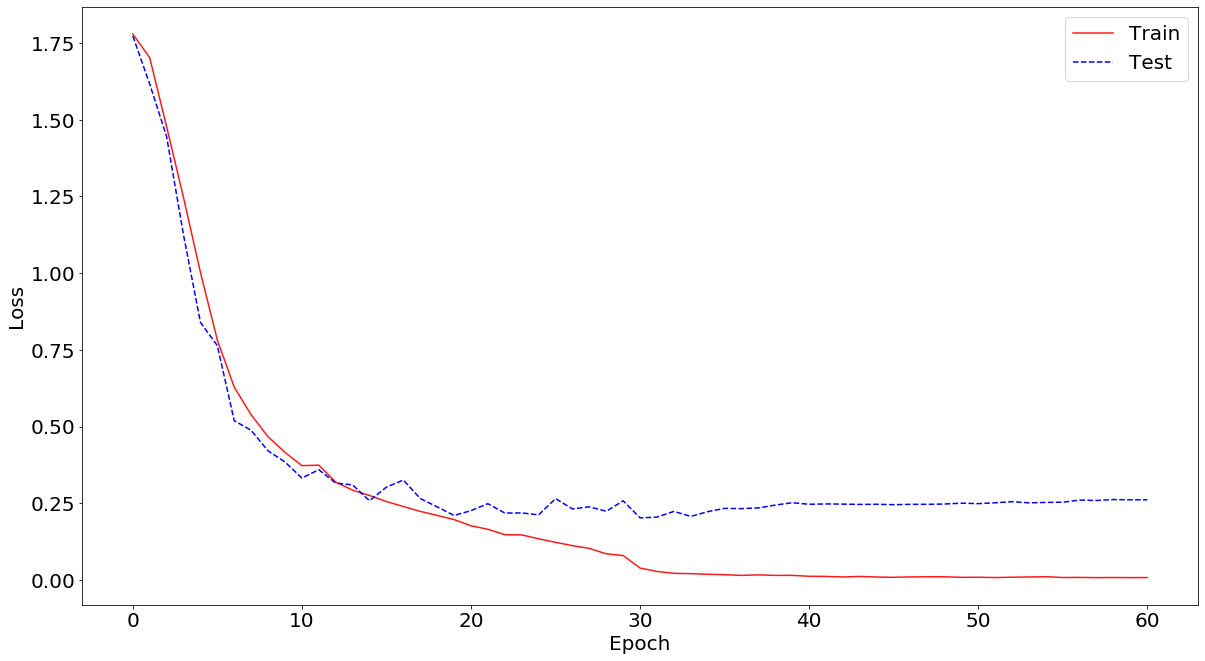

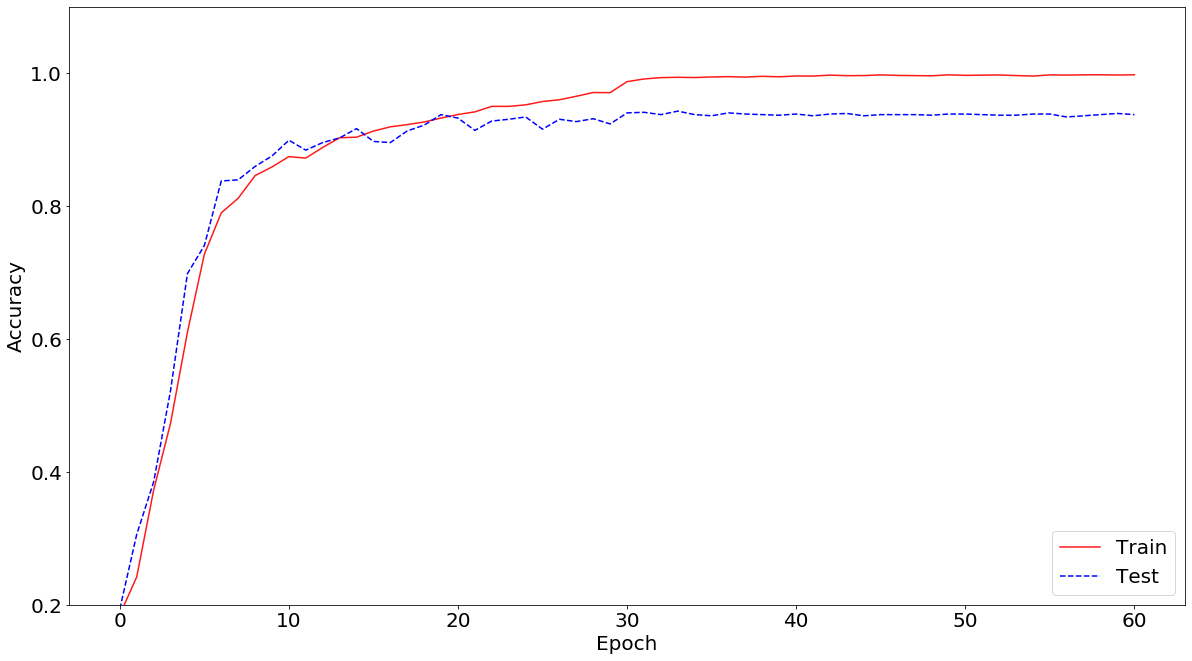

In [14]:
helpers.plot_train_history(history, x_ticks_vertical=True)

In [15]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


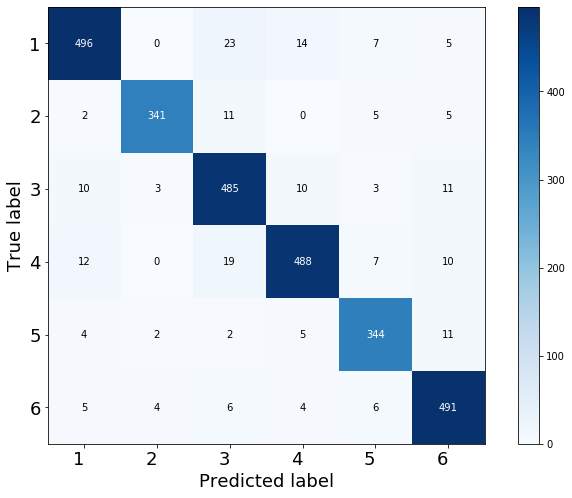

In [16]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False,  
                          cmap=plt.cm.Blues,
                          size=(10,7))

In [17]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)
result_acc = 'acc_' + model_file
result_path = os.path.join(results_path, result_acc)

df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

  CLASS   ACCURACY
0     1  91.009174
1     2  93.681319
2     3  92.911877
3     4  91.044776
4     5  93.478261
5     6  95.155039


In [18]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(y_trues, yhat_probs)))
print("Precision: {0}".format(precision_score(y_trues, yhat_probs, average='weighted')))
print("Recall: {0}".format(recall_score(y_trues, yhat_probs, average='weighted')))
print("F1-Score: {0}".format(f1_score(y_trues, yhat_probs, average='weighted')))

              precision    recall  f1-score   support

           1       0.94      0.91      0.92       545
           2       0.97      0.94      0.96       364
           3       0.89      0.93      0.91       522
           4       0.94      0.91      0.92       536
           5       0.92      0.93      0.93       368
           6       0.92      0.95      0.94       516

   micro avg       0.93      0.93      0.93      2851
   macro avg       0.56      0.56      0.56      2851
weighted avg       0.93      0.93      0.93      2851

Accuracy: 0.9277446509996492
Precision: 0.928450991084546
Recall: 0.9277446509996492
F1-Score: 0.9278447197717846


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 10, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
